# Detekcja anomalii w systemach ICT

### Magdalena Gołębiowska (255540)
### semestr letni 2023/2024

## Zbiór danych *ForestCover/Covertype* [(źródło)](https://odds.cs.stonybrook.edu/forestcovercovertype-dataset/)

liczba próbek: 286048  
wymiar: 10  
wartości odstające: 2747 (0.9%)

Oryginalny zbiór danych jest zbiorem do problemu klasyfikacji wieloklasowej. Służy on do przewidywania gęstości lasu (lesistości) na danych obszarze tylko z danych kartograficznych. Do zbioru danych OoD wybrano tylko attrybuty numeryczne oraz dwie klasy z czego jedna jest mniej liczna i uważana jest za dane odstające. Nazwy atrybutów: Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways, Hillshade_9am, Hillshade_Noon, Hillshade_3pm, Horizontal_Distance_To_Fire_Points. Każdy z nich ma typ *integer*.

In [21]:
import numpy as np 
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib

f = scipy.io.loadmat('cover.mat')
print(f.keys())

X = np.array(f.get('X'))
y = np.array(f.get('y')).ravel().astype(int)

print(X.shape)
print(y.shape)

y_normal = []
y_ood = []
X_normal = []
X_ood = []

for i in range(0, y.shape[0]):
    if y[i] == 1:
        y_ood.append(y[i])
        X_ood.append(X[i])
    else:
        y_normal.append(y[i])
        X_normal.append(X[i])

X_normal = np.array(X_normal)
X_ood = np.array(X_ood)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_normal, y_normal, test_size=0.33, random_state=61)

XX = np.concatenate((X_test,X_ood), axis=0)
print(XX.shape)

yy = [0]*X_test.shape[0] + [1]*X_ood.shape[0]      # 0 - ID, 1 - OOD
yy = np.array(yy)

print("Statystyki danych:")
print("Średnia", np.mean(XX, axis=0))
print("Max", np.max(XX, axis=0))
print("Min", np.min(XX, axis=0))
print("Var", np.var(XX, axis=0))


dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(286048, 10)
(286048,)
(96237, 10)
Statystyki danych:
Średnia [2901.20729034  151.84382306   13.69716429  274.92581855   45.70307678
 2383.27575673  214.19929965  225.09989921  142.16543533 2125.73709696]
Max [3431  360   66 1397  598 7116  254  254  254 7173]
Min [1988    0    0    0 -163    0    0    0    0    0]
Var [4.74495973e+04 1.15037170e+04 5.21405297e+01 4.41267877e+04
 3.30696602e+03 2.61242179e+06 6.25311756e+02 3.47776132e+02
 1.37031295e+03 2.01518282e+06]


Aby zapoznać się z rozkładem danych, stworzono histogram jednej z wybranych cech. Wyraźnie widoczne są wartości odstające, których liczność jest mniejsza. Narysowano również wykres danych w zależności cechy $x_8$ do $x_1$. Widoczny jest jeden klaster danych oraz grupa danych wyraźnie od niego odsunięta. Po statystykach danych widać również, że rozrzut danych jest duży. Zmniejszenie wymiaru danych metodą t-SNE (*t-distributed stochastic neighbor embedding*) nie zachowało podziału na rozkłady danych odstających i normalnych. 

Text(0, 0.5, 'częstość')

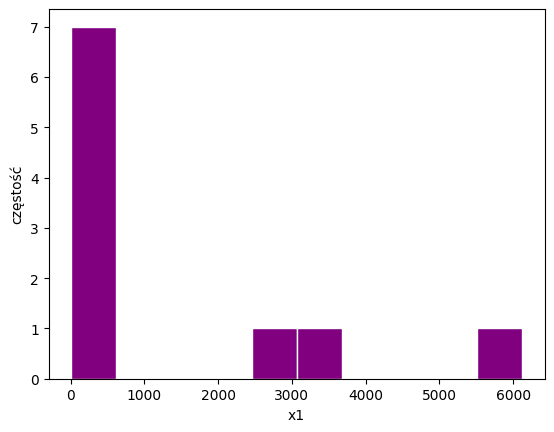

In [7]:
plt.hist(X[0], edgecolor = "white", color = "purple")
plt.xlabel('x1')
plt.ylabel('częstość')

Text(0, 0.5, 'x8')

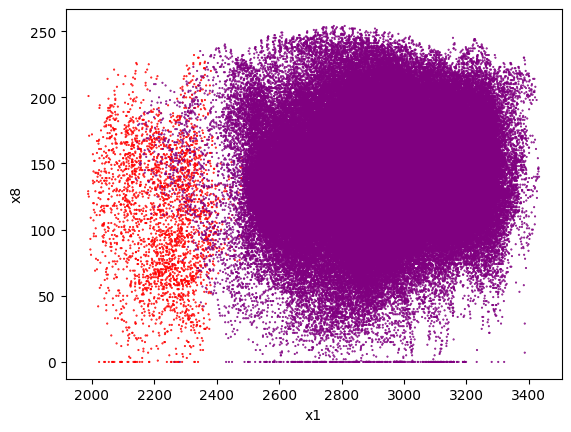

In [9]:
colors = ['purple', 'red']
plt.scatter(X[:, 0], X[:, 8], s=.25, label="Data points", c=y, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('x1')
plt.ylabel('x8')

Wykonano również zmiejszenie wymiarowości danych za pomocą metody T-SNE, by dokonać ich pełnej wizualizacji. Metoda ta nie zachowała jednak odrębności danych spoza rozkładu.

[[  72.18166   103.7316  ]
 [  72.9094    105.29126 ]
 [  35.12238   134.67464 ]
 ...
 [ -50.82645  -130.05551 ]
 [ -50.842922 -130.11528 ]
 [ -50.85503  -130.15508 ]]


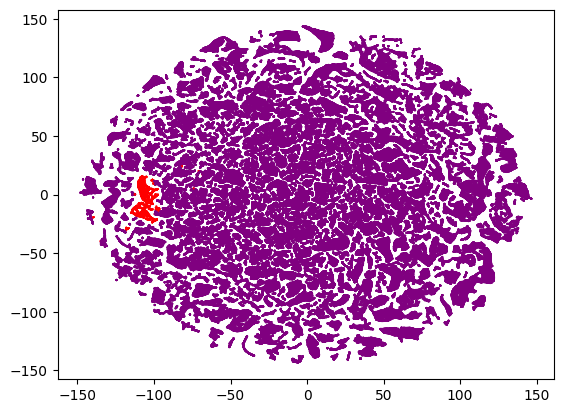

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

n_components = 2
tsne = TSNE(n_components)
result = tsne.fit_transform(X)

print(result)
plt.scatter( result[:,0], result[:,1], s=.25, label="Data points", c=y, cmap=matplotlib.colors.ListedColormap(colors))

### LOF

*Local outlier factor* to algorytm oparty na koncepcji lokalnej gęstości danych, gdzie lokalność określana jest *k* najbliższych sąsiadów. Ich odległość jest podstawą do obliczenia gęstości.     

Oznaczamy $k$ najbliższych sąsiadów A jako $N_k(A)$. Wprowadza się pojęcie *reachability distance*. Przez $k-\mathrm{distance}(A)$ oznaczamy odległość punktu A do $k$-tego najbliższego sąsiada. *Reachability distance* między punktami A i B definiowane jako:  
$$\mathrm{reachability-distance}_k(A,B) = \max{\{k-\mathrm{distance}(B), d(A, B)\}}$$  
W ten sposób punkty, które są $k$ najbliższymi sąsiadami B uważane są za tak samo odległe (w sensie *reachability distance*) jak sam punkt B. 
Na tej podstawie definiuje się *local reachability density* obiektu A:  
$$ \mathrm{lrd}_k (A) = 1 / \left(\frac{\sum_{B \in N_k(A)} \mathrm{reachability-distance}_k(A,B)}{|N_k(A)|}\right)$$  
czyli jest to odwrotność średniego *reachability distance* obiektu A od jego sąsiadów.

Algorytm następnie porównuje gęstość punktu z gęstościami jego sąsiadów i w ten sposób identyfikuje obszary o podobnej gęstości należące najprawdopodobniej do tego samego klastra. Punkty danych, które mają dużo niższą gęstość od swoich sąsiadów są uważane za wartości odstające.   
Porównywanie tych lokalnych gęstości odbywa się poprzez metrykę:  
$$\mathrm{LOF}_k(A) = \frac{\sum_{B \in N_k(A)}\frac{\mathrm{lrd}_k(B)}{\mathrm{lrd}_k(A)}}{|N_k(A)|}$$

Ostatecznie otrzymujemy warunki:  
$$\mathrm{LOF}(k) ~ 1$$ to gęstość podobna do gęstości sąsiadów,  
$$\mathrm{LOF}(k) < 1$$ to gęstość wyższa od gęstości sąsiadów,  
$$\mathrm{LOF}(k) > 1$$ to gęstość niższa od gęstości sąsiadów i punkt jest wartością odstającą.  

Metodę wykorzystano w trybie *novelty*, co oznacza, że model został dopasowany do rozkładu danych treningowych i dane spoza niego, będą uważane za dane odstające.




n_neighbors =  5
-1.01307796889364
-1.0601108438278122
-4.210499591190615
n_neighbors =  10
-1.0196304136118808
-1.0399267646370156
-3.340824561509364
n_neighbors =  50
-1.026879813053641
-1.0304530463291677
-2.129917205271668
n_neighbors =  100
-1.0290824958194453
-1.030771757078823
-1.9148500333854581


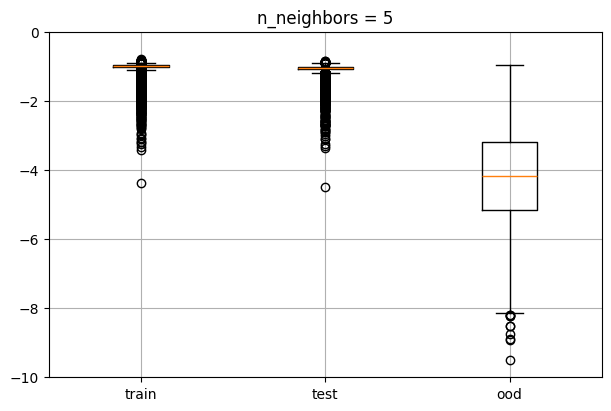

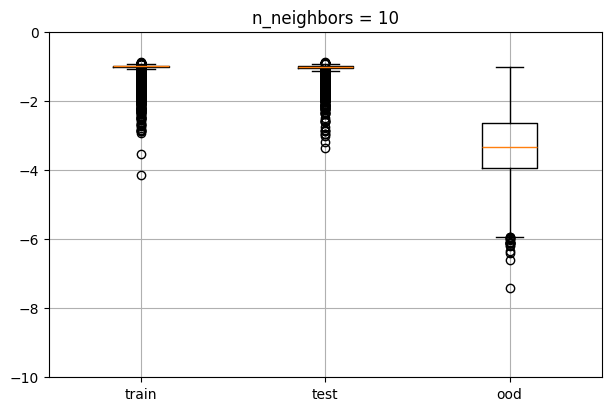

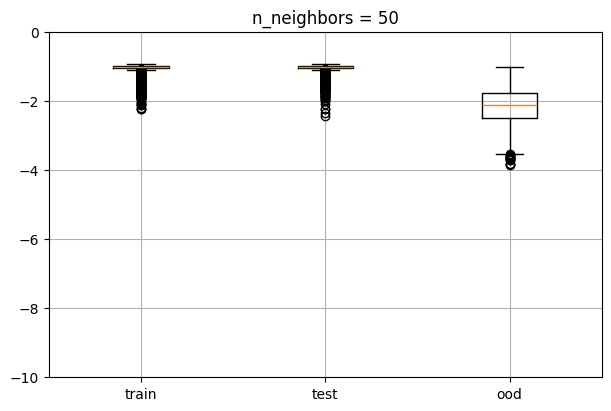

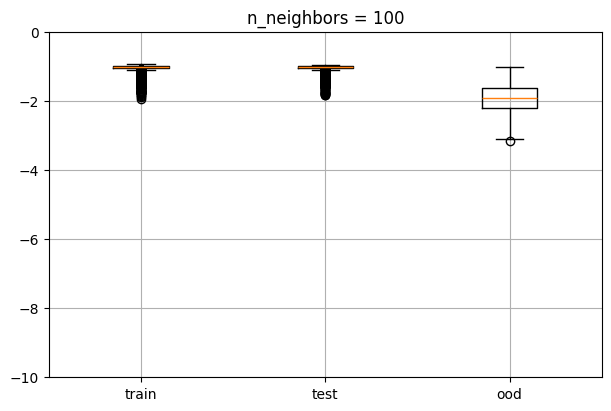

In [3]:
from sklearn.neighbors import LocalOutlierFactor

n_neighbors = [5, 10, 50, 100]
train_scores = []
test_scores = []
ood_scores = []

for i in range(len(n_neighbors)):
    model = LocalOutlierFactor(n_neighbors=n_neighbors[i], novelty=True)
    model.fit(X_train)
    
    train_scores.append(model.score_samples(X_train))
    test_scores.append(model.score_samples(X_test))
    ood_scores.append(model.score_samples(X_ood))

    if 1:
        print('n_neighbors = ', n_neighbors[i])
        print(np.mean(train_scores[i]))
        print(np.mean(test_scores[i]))
        print(np.mean(ood_scores[i]))

    # boxplot
    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
    ax.set_ylim([-10, 0])
    labels = ['train', 'test', 'ood']
    ax.boxplot([train_scores[i], test_scores[i], ood_scores[i]], labels=labels)
    ax.grid()
    string = 'n_neighbors = ' + str(n_neighbors[i])
    plt.title(label = string)

plt.show()

[-0.52330557 -0.50947337 -0.49132381 ...  0.10781918  0.06404484
 -0.04552773]


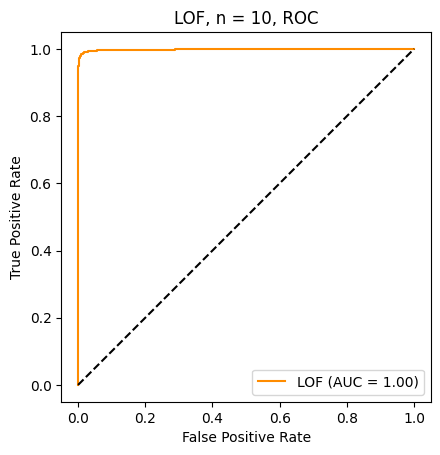

348
-0.13728079277687022
[[92626   864]
 [   43  2704]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     93490
           1       0.76      0.98      0.86      2747

    accuracy                           0.99     96237
   macro avg       0.88      0.99      0.93     96237
weighted avg       0.99      0.99      0.99     96237



In [23]:
# ROC curve
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report

model = LocalOutlierFactor(n_neighbors=10, novelty=True)
model.fit(X_train)

# samples with a negative LOF score (indicating they are less dense than their neighbors) are considered outliers, 
# those with a positive LOF score (indicating they are more dense than their neighbors) are considered inliers
yy_score = -model.decision_function(XX)
print(yy_score)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="LOF",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = "LOF, n = 10, ROC"
plt.title(string)
plt.legend()
plt.show()

# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, yy_score)
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = yy_score.copy()
yy_pred = np.where(yy_score <=  thresholds[np.argmax(tpr - fpr)], 0, 1)

print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))


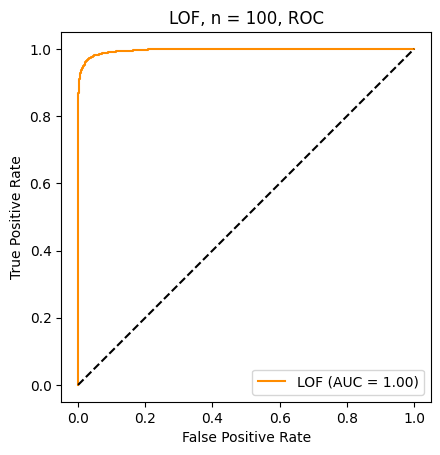

626
-0.32690757467967724
[[90816  2674]
 [   85  2662]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     93490
           1       0.50      0.97      0.66      2747

    accuracy                           0.97     96237
   macro avg       0.75      0.97      0.82     96237
weighted avg       0.98      0.97      0.98     96237



In [24]:
# ROC curve
from sklearn.metrics import RocCurveDisplay

model = LocalOutlierFactor(n_neighbors=100, novelty=True)
model.fit(X_train)

# samples with a negative LOF score (indicating they are less dense than their neighbors) are considered outliers, 
# while those with a positive LOF score (indicating they are more dense than their neighbors) are considered inliers
yy_score = -model.decision_function(XX)
RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="LOF",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = "LOF, n = 100, ROC"
plt.title(string)
plt.legend()
plt.show()

# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, yy_score)
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = yy_score.copy()
yy_pred = np.where(yy_score <=  thresholds[np.argmax(tpr - fpr)], 0, 1)

print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))


Zbadano 4 różne wartości $k$ - wielkości lokalnego sąsiedztwa. Dla każdej z nich obliczono *outlierness score*, czyli wcześniej zdefiniowaną wartość $\mathrm{LOF}$ i narysowano wykresy pudełkowe. Widać, że wyznaczone "gęstości" danych treningowych i testowych są podobne. Wraz ze zwiększaniem się liczby sąsiadów, wartości $\mathrm{LOF}$ danych odstających zbliżają się do wartości danych testowych i treningowych. Dzieje się tak, ponieważ zwiększając liczbę sąsiadów, zwiększamy obszar lokalności punktów. Niemiej jednak, skuteczność metody przy $n=10$ oraz $n=100$ pozostaje taka sama i detekcja jest skuteczna (pole pod krzywą ROC wynosi 1). Wyznaczono próg decyzyjny dla każdej liczby sąsiadów i dla tego progu dokonano etykietyzacji 0 - punkt id, 1 - punkt ood. Na tej podstawie wyznaczono macierze błędów oraz metryki klasyfikacji. Model jednak ma jednak niską precyzję dla klasy ood, co oznacza, że część normalnych próbek została oceniona jako próbki odstające. Dla drugiego modelu ok. 50% próbek ocenionych jako ood tak naprawdę jest id; stąd model z mniejszym sąsiedztwem jest lepszy, co widać też po uzyskanej przez modele dokładności. Nie wszystkie próbki odstające zostały wykryte. 

### kNN

Algorytm $k$ najbliższych sąsiadów jest nadzorowanym algorytmem uczenia maszynowego, który można jednak użyć również w uczeniu nienadzorowanym, np. do detekcji anomalii.  
W problemie klasyfikacji algorytm ten oblicza odgległość punktu od innych punktów danych i wybiera jego $k$ najbliższych sąsiadów. Punktowi przypisywana jest najczęstsza klasa występująca wśród jego sąsiadów. Odgległość może być obliczana z wykorzystaniem różnych metryk, najczęściej jest to metryka Euklidesowa $d(A, B) = \left(\sum_{i=1}^N (x_{i, A} - x_{i, B})^2\right)^{1/2}$.  

Do problemu detekcji anomalii ustala się próg średniej odległości punktu od jego $k$ sąsiadów. Duża średnia odległość wskazuje na to, że punkt jest wartością odstającą. 

56.52299518832179
65.28268686717216
314.0573469731056


Text(0.5, 1.0, 'n_neighbors = 10')

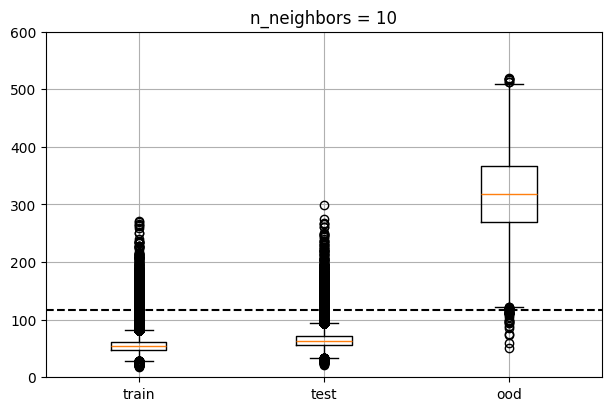

In [28]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = [10, 50, 100]

model = NearestNeighbors(n_neighbors = n_neighbors[0])
model.fit(X_train)

distances, indexes = model.kneighbors(X)
cutoff = [117.0311]
# average distance for each observation over k neighbors
distances_train, indexes_train = model.kneighbors(X_train)
distances_test, indexes_test = model.kneighbors(X_test)
distances_ood, indexes_ood = model.kneighbors(X_ood)

if 1:
    print(np.mean(np.mean(distances_train, axis = 1)))
    print(np.mean(np.mean(distances_test, axis = 1)))
    print(np.mean(np.mean(distances_ood, axis = 1)))
    
# boxplot
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
labels = ['train', 'test', 'ood']
ax.boxplot([np.mean(distances_train, axis = 1), np.mean(distances_test, axis = 1), np.mean(distances_ood, axis = 1)], labels=labels)
ax.grid()
ax.set_ylim([0, 600])
string = 'n_neighbors = ' + str(n_neighbors[0])
plt.axhline(y=cutoff[0], color='k', linestyle='--')
plt.title(label = string)


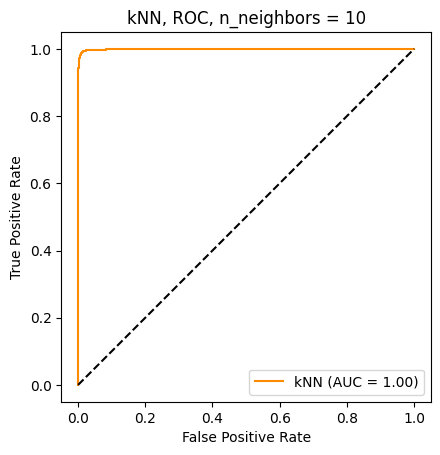

384
117.03111513918218
[0 0 0 ... 1 1 0]
[[92354  1136]
 [   27  2720]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     93490
           1       0.71      0.99      0.82      2747

    accuracy                           0.99     96237
   macro avg       0.85      0.99      0.91     96237
weighted avg       0.99      0.99      0.99     96237



In [33]:
ood = []
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report

distances, indexes = model.kneighbors(XX)

RocCurveDisplay.from_predictions(
        yy,
        distances.mean(axis = 1),
        name="kNN",
        color="darkorange",
        pos_label=1
    )
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = 'kNN, ROC, n_neighbors = ' + str(n_neighbors[0])
plt.title(string)
plt.legend()
plt.show()
# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, distances.mean(axis = 1))
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = distances.copy()
yy_pred = np.where(distances.mean(axis=1) <=  thresholds[np.argmax(tpr - fpr)], 0, 1)
print(yy_pred)
print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))



116.49421693640627
119.70027439790971
345.1292209987783


Text(0.5, 1.0, 'n_neighbors = 50')

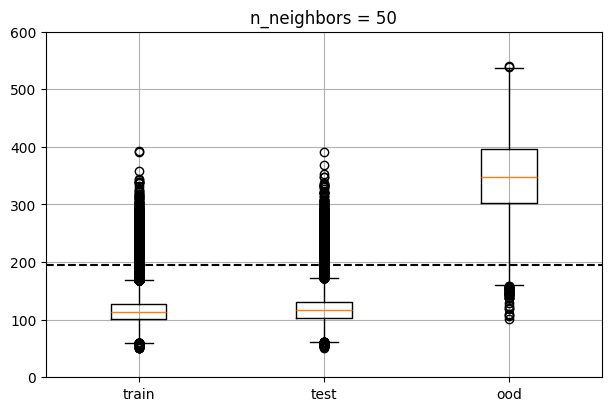

In [41]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(n_neighbors = n_neighbors[1])
model.fit(X_train)

distances, indexes = model.kneighbors(X)
cutoff = [195.58935516534305]
# average distance for each observation over k neighbors
distances_train, indexes_train = model.kneighbors(X_train)
distances_test, indexes_test = model.kneighbors(X_test)
distances_ood, indexes_ood = model.kneighbors(X_ood)

if 1:
    print(np.mean(np.mean(distances_train, axis = 1)))
    print(np.mean(np.mean(distances_test, axis = 1)))
    print(np.mean(np.mean(distances_ood, axis = 1)))

# boxplot
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
labels = ['train', 'test', 'ood']
ax.boxplot([np.mean(distances_train, axis = 1), np.mean(distances_test, axis = 1), np.mean(distances_ood, axis = 1)], labels=labels)
ax.grid()
ax.set_ylim([0, 600])
string = 'n_neighbors = ' + str(n_neighbors[1])
plt.axhline(y=cutoff[0], color='k', linestyle='--')
plt.title(label = string)


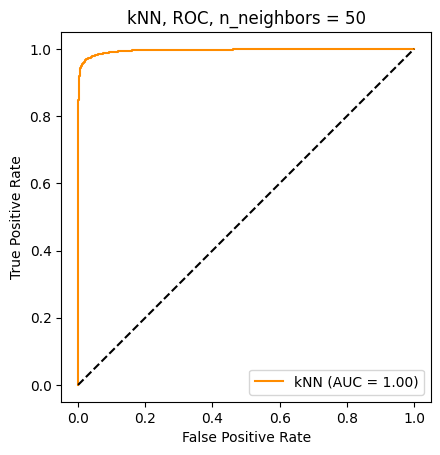

608
195.58935516534305
[0 0 0 ... 0 0 0]
[[92087  1403]
 [  114  2633]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     93490
           1       0.65      0.96      0.78      2747

    accuracy                           0.98     96237
   macro avg       0.83      0.97      0.88     96237
weighted avg       0.99      0.98      0.99     96237



In [42]:
ood = []
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report

distances, indexes = model.kneighbors(XX)

RocCurveDisplay.from_predictions(
        yy,
        distances.mean(axis = 1),
        name="kNN",
        color="darkorange",
        pos_label=1
    )
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = 'kNN, ROC, n_neighbors = ' + str(n_neighbors[1])
plt.title(string)
plt.legend()
plt.show()
# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, distances.mean(axis = 1))
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = distances.copy()
yy_pred = np.where(distances.mean(axis=1) <=  thresholds[np.argmax(tpr - fpr)], 0, 1)
print(yy_pred)
print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))



150.16183873434161
152.1083031975102
364.15722284826995


Text(0.5, 1.0, 'n_neighbors = 100')

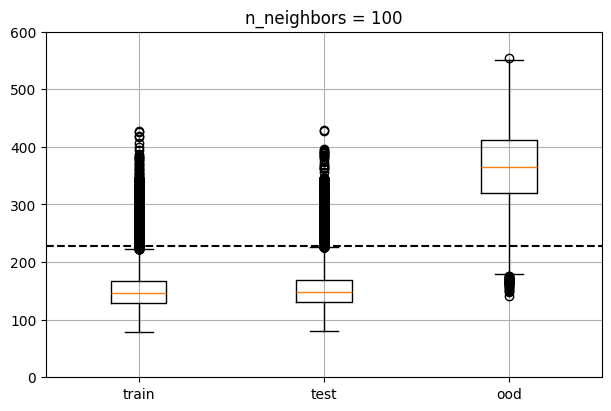

In [40]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(n_neighbors = n_neighbors[2])
model.fit(X_train)

distances, indexes = model.kneighbors(X)
cutoff = [228.34180223635707]
# average distance for each observation over k neighbors
distances_train, indexes_train = model.kneighbors(X_train)
distances_test, indexes_test = model.kneighbors(X_test)
distances_ood, indexes_ood = model.kneighbors(X_ood)


if 1:
    print(np.mean(np.mean(distances_train, axis = 1)))
    print(np.mean(np.mean(distances_test, axis = 1)))
    print(np.mean(np.mean(distances_ood, axis = 1)))


# boxplot
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
labels = ['train', 'test', 'ood']
ax.boxplot([np.mean(distances_train, axis = 1), np.mean(distances_test, axis = 1), np.mean(distances_ood, axis = 1)], labels=labels)
ax.grid()
ax.set_ylim([0, 600])
string = 'n_neighbors = ' + str(n_neighbors[2])
plt.axhline(y=cutoff[0], color='k', linestyle='--')
plt.title(label = string)


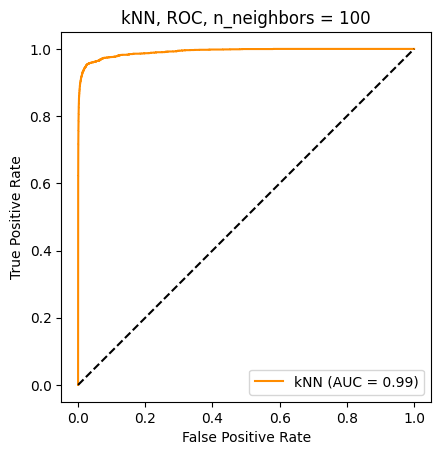

814
228.34180223635707
[0 0 0 ... 0 0 0]
[[90952  2538]
 [  126  2621]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     93490
           1       0.51      0.95      0.66      2747

    accuracy                           0.97     96237
   macro avg       0.75      0.96      0.82     96237
weighted avg       0.98      0.97      0.98     96237



In [39]:
ood = []
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report

distances, indexes = model.kneighbors(XX)

RocCurveDisplay.from_predictions(
        yy,
        distances.mean(axis = 1),
        name="kNN",
        color="darkorange",
        pos_label=1
    )
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = 'kNN, ROC, n_neighbors = ' + str(n_neighbors[2])
plt.title(string)
plt.legend()
plt.show()
# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, distances.mean(axis = 1))
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = distances.copy()
yy_pred = np.where(distances.mean(axis=1) <=  thresholds[np.argmax(tpr - fpr)], 0, 1)
print(yy_pred)
print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))



Przeprowadzone eksperymenty pokazują, że średnie odległości danych testowych i treningowych są podobne. Większe odległości od swoich sąsiadów wykazują punkty odstające. Im większa liczba sąsiadów $k$, tym większe są średnie odległości. Jednocześnie mniejsza liczba sąsiadów bardziej oddala od siebie średnie odległości zbioru normalnego i zawierającego tylko anomalnie. Dzieje się tak, ponieważ biorąc pod uwagę mniej punktów do sąsiedztwa jest ono bardziej "lokalne", tzn. bardziej odizolowany punkt będzie miał jako swoich sąsiadów inne odizolowane punkty.
Dla każdej z badanych liczby sąsiadów, wyznaczono optymalny w sensie balansu między TPR a FPR, próg decyzyjny. Na jego podstawie dokonano klasyfikacji danych spoza rozkładu danych normalnych. Model z najmniejszym sąsiedztwem osiąga najlepsze wyniki. Tak jak w przypadku LOF, dużo próbek id klasyfikowanych jest jako ood i nie wszystkie ood są sklasyfikowane poprawnie. 



### Elliptical Envelope

Algorytm ten wyznacza hiperpowierzchnię eliptyczną (w 2D elipsa, w 3D elipsoida) wokół punktów danych. Metoda ta modeluje dane jako kilku wymiarowy rozkład Gaussowski $MVN(\mu, \Sigma)$ z macierzą kowariancji $\Sigma$ i stara się wyznaczyć elipsę, która obejmuje jak najwięcej danych. Dane, które są poza hiperpłaszczyzną uważane są za anomalnie. 

Algorytm ten wybiera nienakładające się na siebie podzbiory danych i oblicza średnią $\mu$ i macierz kowariancji $\Sigma$ dla każdego atrybytu dla każdego podzbioru. Do obliczania odległości używana jest odległość Mahalanobisa jako dystans między punktem (będącym wektorem cech) $x$ a rozkładem $D$:  

$$d_{MH}(x, D) = \sqrt{(x-\mu)^T \Sigma^{-1}(x-\mu)}$$  

Odległość Mahalanobisa mierzy o ile wartości standardowych punkt jest odległy od średniej rozkładu. 

Dane porządkowane są rosnąco według wyznaczonej odległości i dystans używany jest jako próg do wyznaczania dnych odstających. 

contamination =  0.0005
-62.89365849962019
-61.22521725622125
-89.39606157474448
contamination =  0.01
-62.89365849962019
-61.22521725622125
-89.39606157474448
contamination =  0.5
-62.89365849962019
-61.22521725622125
-89.39606157474448


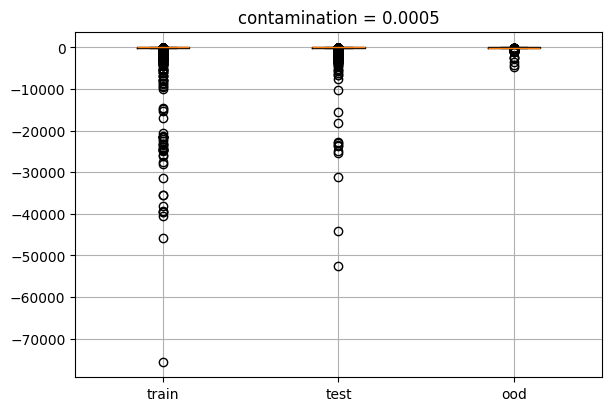

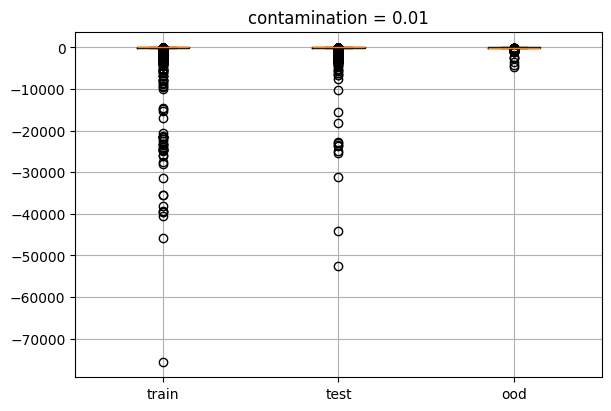

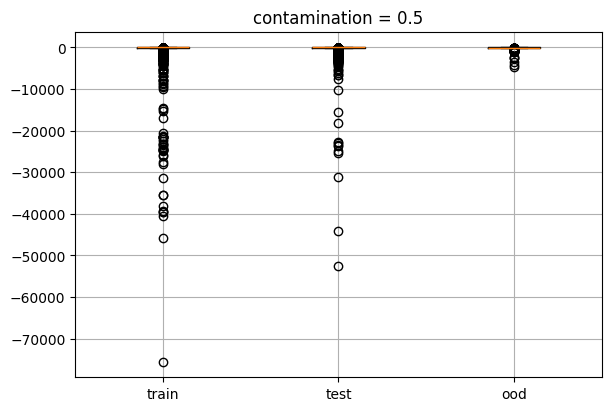

In [48]:
from sklearn.covariance import EllipticEnvelope

cont = [0.0005, 0.01, 0.5]
train_scores = []
test_scores = []
ood_scores = []

for i in range(len(cont)):
    model = EllipticEnvelope(contamination=cont[i], random_state=42)

    model.fit(X_train)

    train_scores.append(model.score_samples(X_train))
    test_scores.append(model.score_samples(X_test))
    ood_scores.append(model.score_samples(X_ood))


    if 1:
        print('contamination = ', cont[i])
        print(np.mean(train_scores[i]))
        print(np.mean(test_scores[i]))
        print(np.mean(ood_scores[i]))


    # boxplot
    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

    labels = ['train', 'test', 'ood']
    ax.boxplot([train_scores[i], test_scores[i], ood_scores[i]], labels=labels)
    ax.grid()
    string = 'contamination = ' + str(cont[i])
    plt.title(label = string)

plt.show()

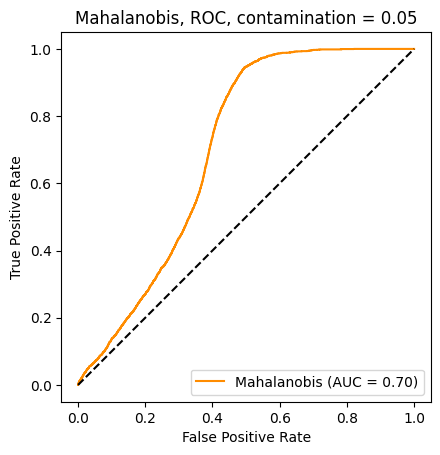

4855
-2344.7836334231592
[[47221 46269]
 [  154  2593]]
              precision    recall  f1-score   support

           0       1.00      0.51      0.67     93490
           1       0.05      0.94      0.10      2747

    accuracy                           0.52     96237
   macro avg       0.52      0.72      0.39     96237
weighted avg       0.97      0.52      0.65     96237



In [43]:
# ROC curve
from sklearn.metrics import RocCurveDisplay
from sklearn.covariance import EllipticEnvelope

model = EllipticEnvelope(contamination=0.0005, random_state=42)
model.fit(X_train)
yy_score = -model.decision_function(XX)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="Mahalanobis",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mahalanobis, ROC, contamination = 0.05")
plt.legend()
plt.show()

# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, yy_score)
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = yy_score.copy()
yy_pred = np.where(yy_score <=  thresholds[np.argmax(tpr - fpr)], 0, 1)

print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))

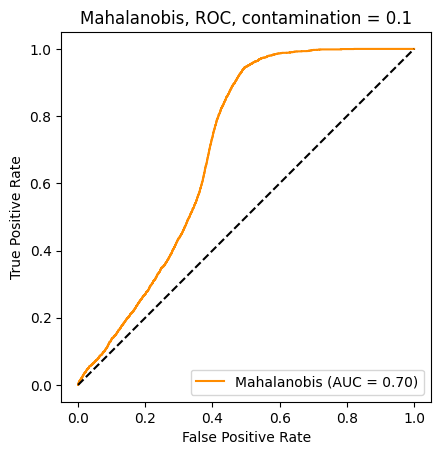

4855
0.312383693863854
[[47221 46269]
 [  154  2593]]
              precision    recall  f1-score   support

           0       1.00      0.51      0.67     93490
           1       0.05      0.94      0.10      2747

    accuracy                           0.52     96237
   macro avg       0.52      0.72      0.39     96237
weighted avg       0.97      0.52      0.65     96237



In [45]:
# ROC curve
from sklearn.metrics import RocCurveDisplay

model = EllipticEnvelope(contamination=0.5, random_state=42)
model.fit(X_train)
yy_score = -model.decision_function(XX)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="Mahalanobis",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mahalanobis, ROC, contamination = 0.1")
plt.legend()
plt.show()
# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, yy_score)
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = yy_score.copy()
yy_pred = np.where(yy_score <=  thresholds[np.argmax(tpr - fpr)], 0, 1)

print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))

Parametr *contamination* określa ile próbek ze zbioru jest danymi odstającymi. Dla tego zbioru zmiana tego parametru nie powoduje żadnej różnicy w wynikach. Wynika to najprawdopodobniej z tego, że zbiór ten nie ma rozkładu normalnego jak sprawdzowno poniżej testem statystycznym Shapiro-Wilka. Niemniej jednak klasyikacja przykładów ood jako ood jest akceptowalna (recall = 0.94). Skuteczność modelu jest zaburzona przez niepoprawną (prawie losową) klasyfikację próbek id jako ood.

In [55]:
from scipy.stats import shapiro

stat, p = shapiro(X)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Nie ma podstaw, by obalić hipotezę zerową.')
else:
    print('Dane nie mają rozkładu normalnego.')

Statistics=0.679, p=0.000
Dane nie mają rozkładu normalnego.


### Wnioski

Metoda oparta na wyznaczaniu *outlierness score* za pomocą odległości Mahalanobisa najgorzej poradziła sobie z danymi. Metoda LOF mniej danych id sklasyfikowała jako ood, ale metoda kNN wyłapała więcej rzeczywistych danych ood, jednocześnie klasyfikując więcej dancyh id jako ood. Wybór najbardziej skutecznej metody byłby więc zależny od tego czy bardziej zależy nam na jak najmniejszej ilości false positivów czy false negativów. W problemu gatunków lasów, nie jest to wybór oczywisty i zależy od preferencji.

## Zbiór danych *Satellite* [(źródło)](https://odds.cs.stonybrook.edu/satellite-dataset/)

liczba próbek: 6435  
wymiar: 36  
wartości odstające: 2036 (32%)

Oryginalny zbiór danych to zbiór wieloklasowy. Klasy określają rodzaj gleby, który znajduje się na zdjęciach 3x3. Trzy najmniej liczne klasy zostały połączone do stworzenia zbioru wartości odstających, a reszta klas tworzy zbiór wartości normalnych. 

In [79]:
import numpy as np 
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

f = scipy.io.loadmat('satellite.mat')
print(f.keys())

X = np.array(f.get('X'))
y = np.array(f.get('y')).ravel().astype(int)

print(X.shape)
print(y.shape)

y_normal = []
y_ood = []
X_normal = []
X_ood = []

for i in range(0, y.shape[0]):
    if y[i] == 1:
        y_ood.append(y[i])
        X_ood.append(X[i])
    else:
        y_normal.append(y[i])
        X_normal.append(X[i])

X_normal = np.array(X_normal)
X_ood = np.array(X_ood)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_normal, y_normal, test_size=0.33, random_state=61)

XX = np.concatenate((X_test,X_ood), axis=0)
print(XX.shape)

yy = [0]*X_test.shape[0] + [1]*X_ood.shape[0]      # 0 - ID, 1 - OOD
yy = np.array(yy)

print("Statystyki danych:")
print("Średnia", np.mean(XX, axis=0))
print("Max", np.max(XX, axis=0))
print("Min", np.min(XX, axis=0))
print("Var", np.var(XX, axis=0))

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(6435, 36)
(6435,)
(3488, 36)
Statystyki danych:
Średnia [66.58027523 76.05848624 98.62385321 84.62557339 66.21100917 75.53985092
 98.3334289  84.50458716 66.04587156 75.27780963 98.14936927 84.47477064
 66.37958716 75.8540711  98.57941514 84.75774083 66.06135321 75.29902523
 98.4165711  84.75372706 65.86639908 75.04587156 98.34145642 84.67975917
 66.4171445  76.08514908 98.61037844 84.74799312 66.09202982 75.52150229
 98.46588303 84.75258028 65.91771789 75.28440367 98.37586009 84.75716743]
Max [102 137 140 154 102 130 145 157 101 128 145 157 101 131 145 154 101 128
 145 157 104 130 145 157 101 131 140 154 101 130 145 157 101 125 145 157]
Min [39 27 53 33 39 27 50 29 40 27 50 29 39 27 50 29 40 27 50 29 39 27 50 29
 39 27 50 29 39 27 50 29 39 27 50 29]
Var [201.77910635 631.22135    284.49096772 492.9028093  198.77772283
 629.59474218 286.22741462 497.54642391 194.57301048 624.86175529
 286.29678286 498.9351433  198.34673

Tak jak poprzednio, wyznaczono podstawowe statystyki dla zbioru. Jako że atrybuty są wartościami pikseli spodziewany jest duży rorzyt danych (wartości od 0 do 255)., co widać po wartościach minimalnych i maksymalnych oraz wariancji. Z histogramu dla ósmego atrybutu wynika, że w danych może być jakaś grupa inna od reszty danych. Nie widać tego jednak po narysowaniu zależności cechy $x_8$ od $x_1$. Po zastosowaniu t-SNE widać, że dane ood są zgrupowane poza danymi id, ale nie wszystkie przykłady mają taką własność.

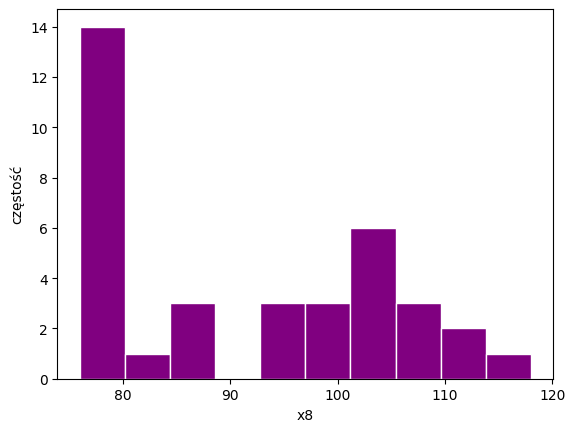

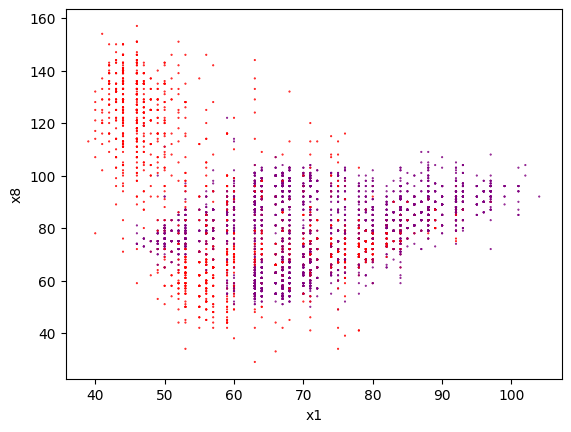

In [15]:
plt.hist(X[7], edgecolor = "white", color = "purple")
plt.xlabel('x8')
plt.ylabel('częstość')
plt.show()

plt.scatter(X[:, 0], X[:, 7], s=.25, label="Data points", c=y, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('x1')
plt.ylabel('x8')
plt.show()

[[ 72.487076   15.139441 ]
 [ 40.3081     -3.3874269]
 [ 34.487144  -17.043264 ]
 ...
 [-16.19314    37.30965  ]
 [-17.965885   45.346893 ]
 [-20.184298   23.05061  ]]


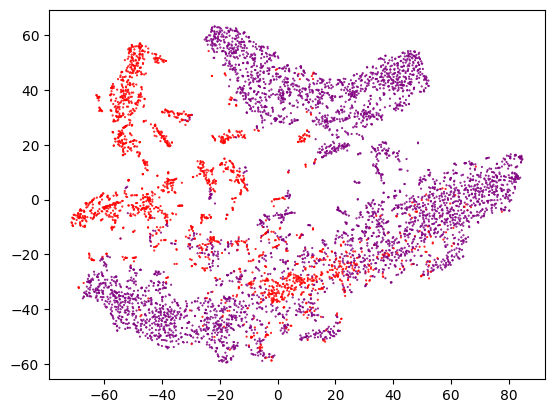

In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

n_components = 2
tsne = TSNE(n_components)
result = tsne.fit_transform(X)

print(result)
plt.scatter( result[:,0], result[:,1], s=.25, label="Data points", c=y, cmap=matplotlib.colors.ListedColormap(colors))

### LOF

n_neighbors =  5
-1.0606476862014877
-1.0883568384309743
-2.335593832040394
n_neighbors =  10
-1.0794434777902873
-1.0960643198040103
-2.6047857212354635
n_neighbors =  50
-1.1195033091330868
-1.1300187121825869
-2.6725328530057793
n_neighbors =  100
-1.12619596854591
-1.1341248779216917
-2.482249380600973


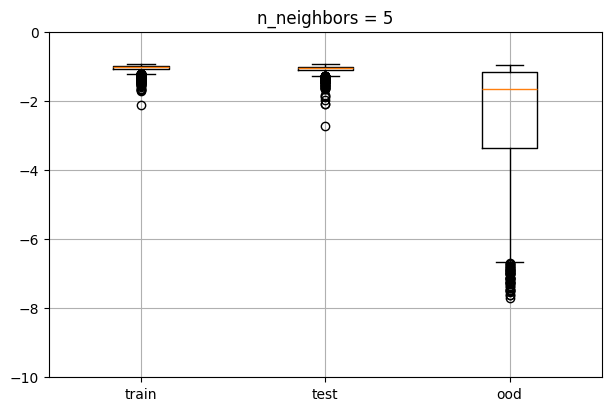

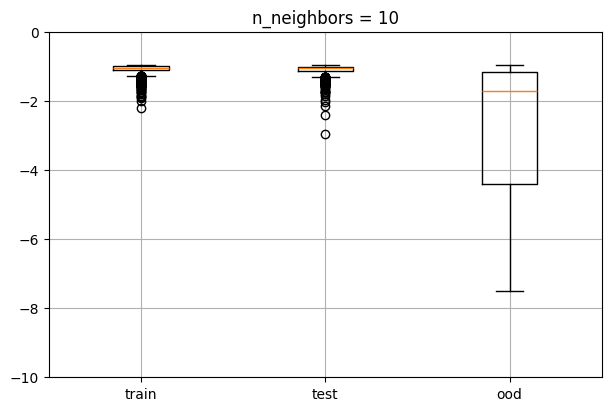

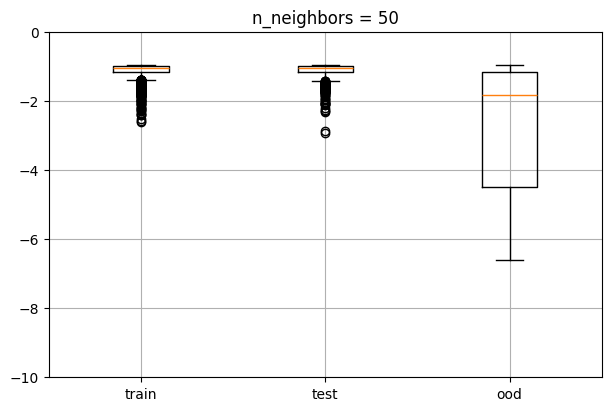

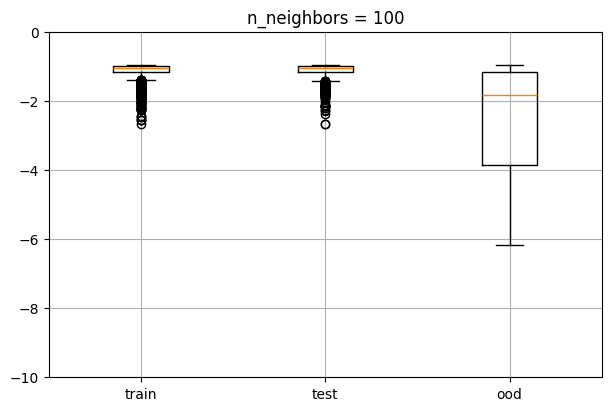

In [44]:
from sklearn.neighbors import LocalOutlierFactor

n_neighbors = [5, 10, 50, 100]
train_scores = []
test_scores = []
ood_scores = []

for i in range(len(n_neighbors)):
    model = LocalOutlierFactor(n_neighbors=n_neighbors[i], novelty=True)
    model.fit(X_train)
    
    train_scores.append(model.score_samples(X_train))
    test_scores.append(model.score_samples(X_test))
    ood_scores.append(model.score_samples(X_ood))

    if 1:
        print('n_neighbors = ', n_neighbors[i])
        print(np.mean(train_scores[i]))
        print(np.mean(test_scores[i]))
        print(np.mean(ood_scores[i]))

    # boxplot
    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
    ax.set_ylim([-10, 0])
    labels = ['train', 'test', 'ood']
    ax.boxplot([train_scores[i], test_scores[i], ood_scores[i]], labels=labels)
    ax.grid()
    string = 'n_neighbors = ' + str(n_neighbors[i])
    plt.title(label = string)

plt.show()

[-0.52797322 -0.14399121 -0.3568254  ... -0.21048041  0.25560412
  0.42218924]


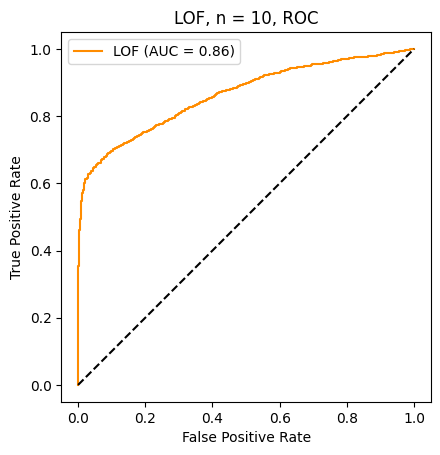

128
-0.1697969180537553
[[1373   79]
 [ 702 1334]]
              precision    recall  f1-score   support

           0       0.66      0.95      0.78      1452
           1       0.94      0.66      0.77      2036

    accuracy                           0.78      3488
   macro avg       0.80      0.80      0.78      3488
weighted avg       0.83      0.78      0.78      3488



In [45]:
# ROC curve
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report

model = LocalOutlierFactor(n_neighbors=10, novelty=True)
model.fit(X_train)

# samples with a negative LOF score (indicating they are less dense than their neighbors) are considered outliers, 
# those with a positive LOF score (indicating they are more dense than their neighbors) are considered inliers
yy_score = -model.decision_function(XX)
print(yy_score)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="LOF",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = "LOF, n = 10, ROC"
plt.title(string)
plt.legend()
plt.show()

# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, yy_score)
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = yy_score.copy()
yy_pred = np.where(yy_score <=  thresholds[np.argmax(tpr - fpr)], 0, 1)

print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))


[-0.50884281 -0.25287414 -0.4306213  ... -0.36052209 -0.07507856
  0.13357717]


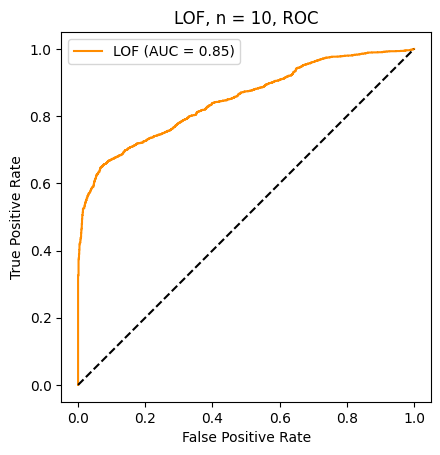

160
-0.060983239312438764
[[1354   98]
 [ 717 1319]]
              precision    recall  f1-score   support

           0       0.65      0.93      0.77      1452
           1       0.93      0.65      0.76      2036

    accuracy                           0.77      3488
   macro avg       0.79      0.79      0.77      3488
weighted avg       0.82      0.77      0.77      3488



In [46]:
# ROC curve
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report

model = LocalOutlierFactor(n_neighbors=50, novelty=True)
model.fit(X_train)

# samples with a negative LOF score (indicating they are less dense than their neighbors) are considered outliers, 
# those with a positive LOF score (indicating they are more dense than their neighbors) are considered inliers
yy_score = -model.decision_function(XX)
print(yy_score)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="LOF",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = "LOF, n = 10, ROC"
plt.title(string)
plt.legend()
plt.show()

# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, yy_score)
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = yy_score.copy()
yy_pred = np.where(yy_score <=  thresholds[np.argmax(tpr - fpr)], 0, 1)

print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))


### kNN

22.247295065030794
25.027812072412242
86.30270299964414


Text(0.5, 1.0, 'n_neighbors = 10')

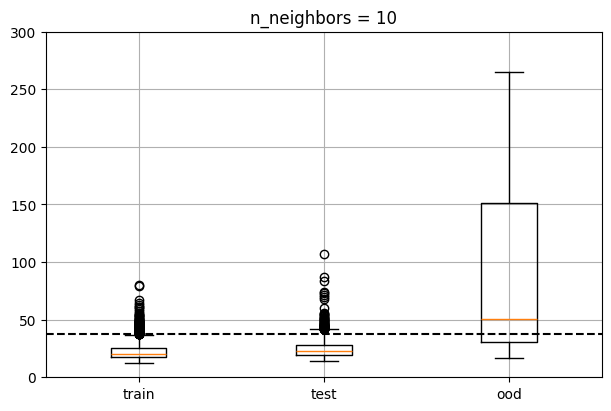

In [50]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = [10, 50, 100]

model = NearestNeighbors(n_neighbors = n_neighbors[0])
model.fit(X_train)

distances, indexes = model.kneighbors(X)
cutoff = [37.13644947795211]
# average distance for each observation over k neighbors
distances_train, indexes_train = model.kneighbors(X_train)
distances_test, indexes_test = model.kneighbors(X_test)
distances_ood, indexes_ood = model.kneighbors(X_ood)

if 1:
    print(np.mean(np.mean(distances_train, axis = 1)))
    print(np.mean(np.mean(distances_test, axis = 1)))
    print(np.mean(np.mean(distances_ood, axis = 1)))
    
# boxplot
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
labels = ['train', 'test', 'ood']
ax.boxplot([np.mean(distances_train, axis = 1), np.mean(distances_test, axis = 1), np.mean(distances_ood, axis = 1)], labels=labels)
ax.grid()
ax.set_ylim([0, 300])
string = 'n_neighbors = ' + str(n_neighbors[0])
plt.axhline(y=cutoff[0], color='k', linestyle='--')
plt.title(label = string)


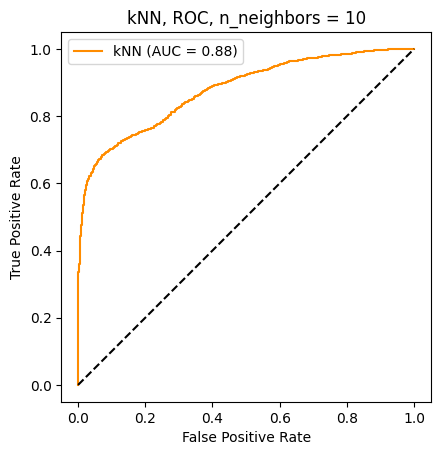

178
37.13644947795211
[0 0 0 ... 0 1 1]
[[1347  105]
 [ 645 1391]]
              precision    recall  f1-score   support

           0       0.68      0.93      0.78      1452
           1       0.93      0.68      0.79      2036

    accuracy                           0.78      3488
   macro avg       0.80      0.81      0.78      3488
weighted avg       0.82      0.78      0.79      3488



In [49]:
ood = []
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report

distances, indexes = model.kneighbors(XX)

RocCurveDisplay.from_predictions(
        yy,
        distances.mean(axis = 1),
        name="kNN",
        color="darkorange",
        pos_label=1
    )
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = 'kNN, ROC, n_neighbors = ' + str(n_neighbors[0])
plt.title(string)
plt.legend()
plt.show()
# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, distances.mean(axis = 1))
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = distances.copy()
yy_pred = np.where(distances.mean(axis=1) <=  thresholds[np.argmax(tpr - fpr)], 0, 1)
print(yy_pred)
print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))



28.85854081769302
29.68587265769208
92.8445850379407


Text(0.5, 1.0, 'n_neighbors = 50')

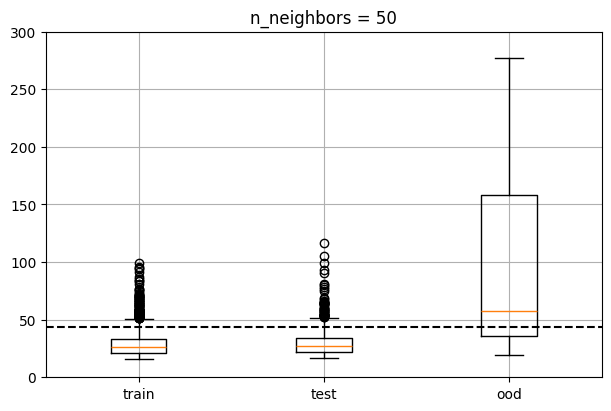

In [53]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = [10, 50, 100]

model = NearestNeighbors(n_neighbors = n_neighbors[1])
model.fit(X_train)

distances, indexes = model.kneighbors(X)
cutoff = [44.04221084761636]
# average distance for each observation over k neighbors
distances_train, indexes_train = model.kneighbors(X_train)
distances_test, indexes_test = model.kneighbors(X_test)
distances_ood, indexes_ood = model.kneighbors(X_ood)

if 1:
    print(np.mean(np.mean(distances_train, axis = 1)))
    print(np.mean(np.mean(distances_test, axis = 1)))
    print(np.mean(np.mean(distances_ood, axis = 1)))
    
# boxplot
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
labels = ['train', 'test', 'ood']
ax.boxplot([np.mean(distances_train, axis = 1), np.mean(distances_test, axis = 1), np.mean(distances_ood, axis = 1)], labels=labels)
ax.grid()
ax.set_ylim([0, 300])
string = 'n_neighbors = ' + str(n_neighbors[1])
plt.axhline(y=cutoff[0], color='k', linestyle='--')
plt.title(label = string)


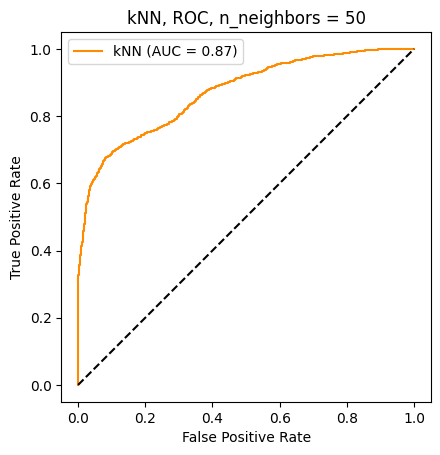

190
44.04221084761636
[0 0 0 ... 0 1 1]
[[1333  119]
 [ 658 1378]]
              precision    recall  f1-score   support

           0       0.67      0.92      0.77      1452
           1       0.92      0.68      0.78      2036

    accuracy                           0.78      3488
   macro avg       0.80      0.80      0.78      3488
weighted avg       0.82      0.78      0.78      3488



In [52]:
ood = []
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report

distances, indexes = model.kneighbors(XX)

RocCurveDisplay.from_predictions(
        yy,
        distances.mean(axis = 1),
        name="kNN",
        color="darkorange",
        pos_label=1
    )
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = 'kNN, ROC, n_neighbors = ' + str(n_neighbors[1])
plt.title(string)
plt.legend()
plt.show()
# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, distances.mean(axis = 1))
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = distances.copy()
yy_pred = np.where(distances.mean(axis=1) <=  thresholds[np.argmax(tpr - fpr)], 0, 1)
print(yy_pred)
print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))



31.88094143635166
32.41514050071469
96.0182703877316


Text(0.5, 1.0, 'n_neighbors = 100')

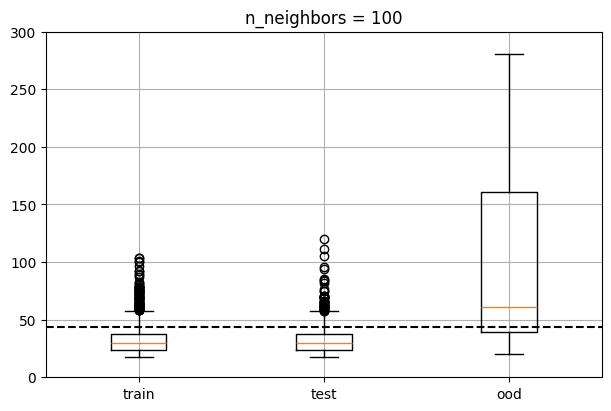

In [54]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = [10, 50, 100]

model = NearestNeighbors(n_neighbors = n_neighbors[2])
model.fit(X_train)

distances, indexes = model.kneighbors(X)
cutoff = [44.04221084761636]
# average distance for each observation over k neighbors
distances_train, indexes_train = model.kneighbors(X_train)
distances_test, indexes_test = model.kneighbors(X_test)
distances_ood, indexes_ood = model.kneighbors(X_ood)

if 1:
    print(np.mean(np.mean(distances_train, axis = 1)))
    print(np.mean(np.mean(distances_test, axis = 1)))
    print(np.mean(np.mean(distances_ood, axis = 1)))
    
# boxplot
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
labels = ['train', 'test', 'ood']
ax.boxplot([np.mean(distances_train, axis = 1), np.mean(distances_test, axis = 1), np.mean(distances_ood, axis = 1)], labels=labels)
ax.grid()
ax.set_ylim([0, 300])
string = 'n_neighbors = ' + str(n_neighbors[2])
plt.axhline(y=cutoff[0], color='k', linestyle='--')
plt.title(label = string)


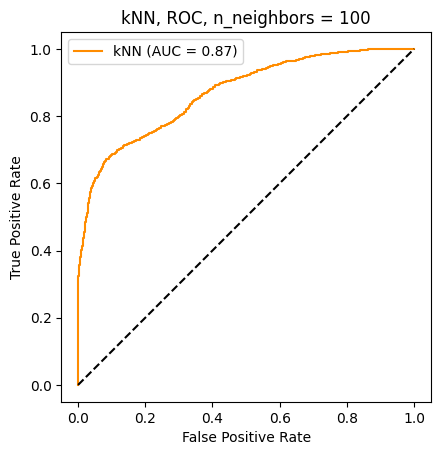

212
47.75114936095317
[0 0 0 ... 0 1 1]
[[1330  122]
 [ 671 1365]]
              precision    recall  f1-score   support

           0       0.66      0.92      0.77      1452
           1       0.92      0.67      0.77      2036

    accuracy                           0.77      3488
   macro avg       0.79      0.79      0.77      3488
weighted avg       0.81      0.77      0.77      3488



In [55]:
ood = []
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report

distances, indexes = model.kneighbors(XX)

RocCurveDisplay.from_predictions(
        yy,
        distances.mean(axis = 1),
        name="kNN",
        color="darkorange",
        pos_label=1
    )
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = 'kNN, ROC, n_neighbors = ' + str(n_neighbors[2])
plt.title(string)
plt.legend()
plt.show()
# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, distances.mean(axis = 1))
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = distances.copy()
yy_pred = np.where(distances.mean(axis=1) <=  thresholds[np.argmax(tpr - fpr)], 0, 1)
print(yy_pred)
print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))



### Elliptical Envelope

contamination =  0.1
-56.09334189917288
-58.971644756771
-554.6300027233037
contamination =  0.2
-56.09334189917288
-58.971644756771
-554.6300027233037
contamination =  0.3
-56.09334189917288
-58.971644756771
-554.6300027233037


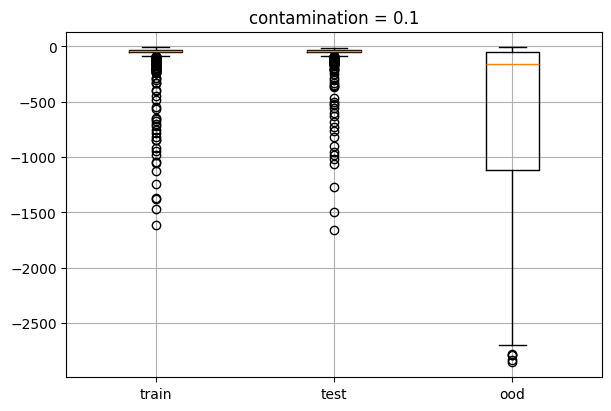

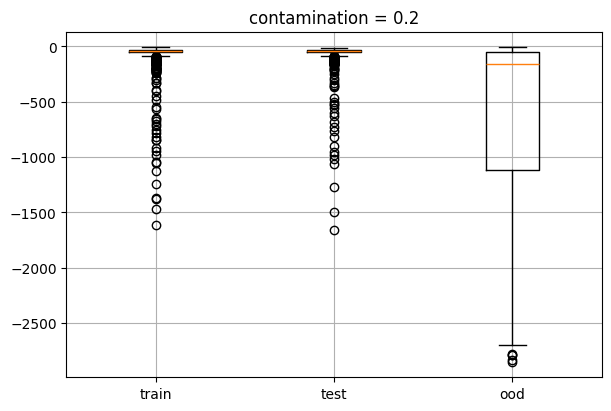

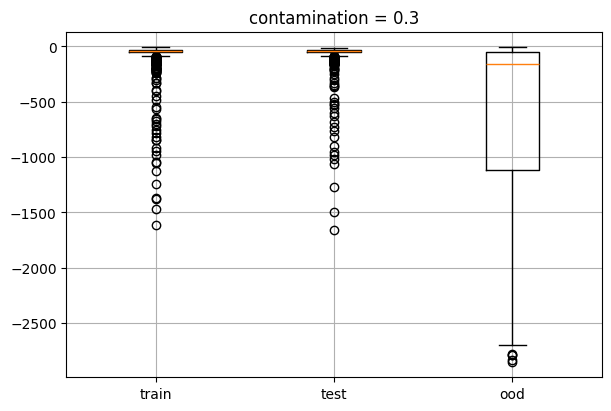

In [83]:
from sklearn.covariance import EllipticEnvelope

cont = [0.1, 0.2, 0.3]
train_scores = []
test_scores = []
ood_scores = []

for i in range(len(cont)):
    model = EllipticEnvelope(contamination=cont[i], random_state=42)

    model.fit(X_train)

    train_scores.append(model.score_samples(X_train))
    test_scores.append(model.score_samples(X_test))
    ood_scores.append(model.score_samples(X_ood))


    if 1:
        print('contamination = ', cont[i])
        print(np.mean(train_scores[i]))
        print(np.mean(test_scores[i]))
        print(np.mean(ood_scores[i]))


    # boxplot
    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

    labels = ['train', 'test', 'ood']
    ax.boxplot([train_scores[i], test_scores[i], ood_scores[i]], labels=labels)
    ax.grid()
    string = 'contamination = ' + str(cont[i])
    plt.title(label = string)

plt.show()

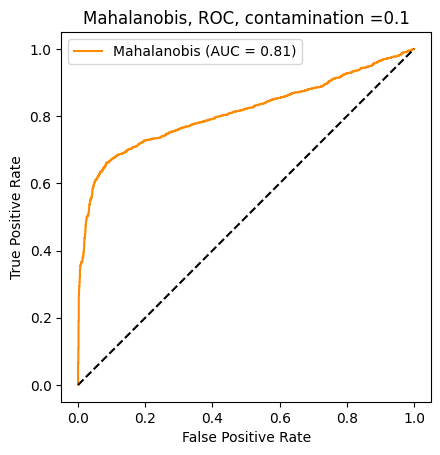

208
3.0125155951256772
[[1329  123]
 [ 691 1345]]
              precision    recall  f1-score   support

           0       0.66      0.92      0.77      1452
           1       0.92      0.66      0.77      2036

    accuracy                           0.77      3488
   macro avg       0.79      0.79      0.77      3488
weighted avg       0.81      0.77      0.77      3488



In [84]:
# ROC curve
from sklearn.metrics import RocCurveDisplay
from sklearn.covariance import EllipticEnvelope

model = EllipticEnvelope(contamination=cont[0], random_state=42)
model.fit(X_train)
yy_score = -model.decision_function(XX)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="Mahalanobis",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = "Mahalanobis, ROC, contamination =" + str(cont[0])
plt.title(string)
plt.legend()
plt.show()

# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, yy_score)
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = yy_score.copy()
yy_pred = np.where(yy_score <=  thresholds[np.argmax(tpr - fpr)], 0, 1)

print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))

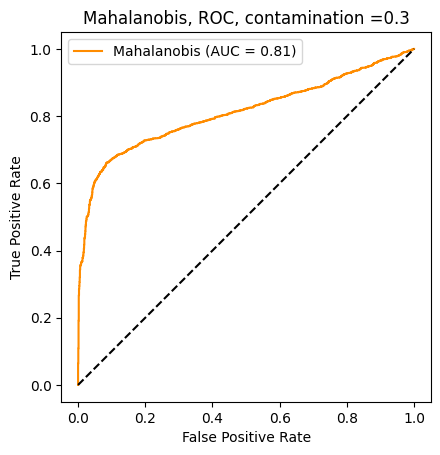

208
35.66303133541304
[[1329  123]
 [ 691 1345]]
              precision    recall  f1-score   support

           0       0.66      0.92      0.77      1452
           1       0.92      0.66      0.77      2036

    accuracy                           0.77      3488
   macro avg       0.79      0.79      0.77      3488
weighted avg       0.81      0.77      0.77      3488



In [85]:
# ROC curve
from sklearn.metrics import RocCurveDisplay
from sklearn.covariance import EllipticEnvelope

model = EllipticEnvelope(contamination=cont[2], random_state=42)
model.fit(X_train)
yy_score = -model.decision_function(XX)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="Mahalanobis",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = "Mahalanobis, ROC, contamination =" + str(cont[2])
plt.title(string)
plt.legend()
plt.show()

# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, yy_score)
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = yy_score.copy()
yy_pred = np.where(yy_score <=  thresholds[np.argmax(tpr - fpr)], 0, 1)

print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))

## Zbiór danych *http (KDDCUP99)* [(źródło)](https://odds.cs.stonybrook.edu/http-kddcup99-dataset/)

liczba próbek: 567479  
wymiar: 3  
wartości odstające: 2211 (0.4%)

Zbiór ten zachował z oryginalnego zbioru danych 3 atrybuty: duration, src_bytes, dst_bytes. Zapis ruchu HTTP z tego zbioru zawiera ataki, które uważane są za dane OoD.

In [63]:
import numpy as np 
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

f = scipy.io.loadmat('satellite.mat')
print(f.keys())

X = np.array(f.get('X'))
y = np.array(f.get('y')).ravel().astype(int)

print(X.shape)
print(y.shape)

y_normal = []
y_ood = []
X_normal = []
X_ood = []

for i in range(0, y.shape[0]):
    if y[i] == 1:
        y_ood.append(y[i])
        X_ood.append(X[i])
    else:
        y_normal.append(y[i])
        X_normal.append(X[i])

X_normal = np.array(X_normal)
X_ood = np.array(X_ood)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_normal, y_normal, test_size=0.33, random_state=61)

XX = np.concatenate((X_test,X_ood), axis=0)
print(XX.shape)

yy = [0]*X_test.shape[0] + [1]*X_ood.shape[0]      # 0 - ID, 1 - OOD
yy = np.array(yy)

print("Statystyki danych:")
print("Średnia", np.mean(XX, axis=0))
print("Max", np.max(XX, axis=0))
print("Min", np.min(XX, axis=0))
print("Var", np.var(XX, axis=0))

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(6435, 36)
(6435,)
(3488, 36)
Statystyki danych:
Średnia [66.58027523 76.05848624 98.62385321 84.62557339 66.21100917 75.53985092
 98.3334289  84.50458716 66.04587156 75.27780963 98.14936927 84.47477064
 66.37958716 75.8540711  98.57941514 84.75774083 66.06135321 75.29902523
 98.4165711  84.75372706 65.86639908 75.04587156 98.34145642 84.67975917
 66.4171445  76.08514908 98.61037844 84.74799312 66.09202982 75.52150229
 98.46588303 84.75258028 65.91771789 75.28440367 98.37586009 84.75716743]
Max [102 137 140 154 102 130 145 157 101 128 145 157 101 131 145 154 101 128
 145 157 104 130 145 157 101 131 140 154 101 130 145 157 101 125 145 157]
Min [39 27 53 33 39 27 50 29 40 27 50 29 39 27 50 29 40 27 50 29 39 27 50 29
 39 27 50 29 39 27 50 29 39 27 50 29]
Var [201.77910635 631.22135    284.49096772 492.9028093  198.77772283
 629.59474218 286.22741462 497.54642391 194.57301048 624.86175529
 286.29678286 498.9351433  198.34673

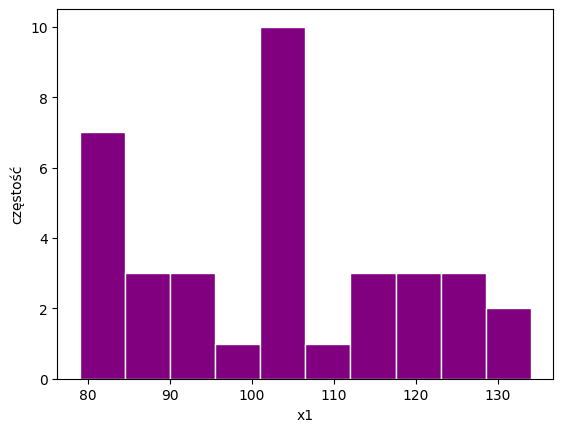

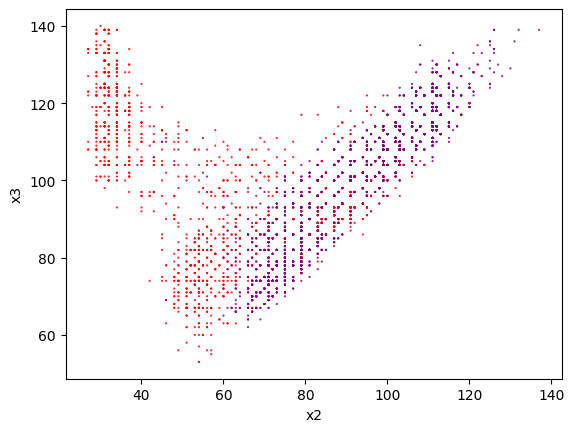

In [18]:
plt.hist(X[0], edgecolor = "white", color = "purple")
plt.xlabel('x1')
plt.ylabel('częstość')
plt.show()

plt.scatter(X[:, 1], X[:, 2], s=.25, label="Data points", c=y, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('x2')
plt.ylabel('x3')
plt.show()

[[ 72.56847   15.287352]
 [ 40.378872  -3.417455]
 [ 34.592705 -16.985868]
 ...
 [-16.247196  37.70312 ]
 [-17.903154  45.64115 ]
 [-20.431658  23.084568]]


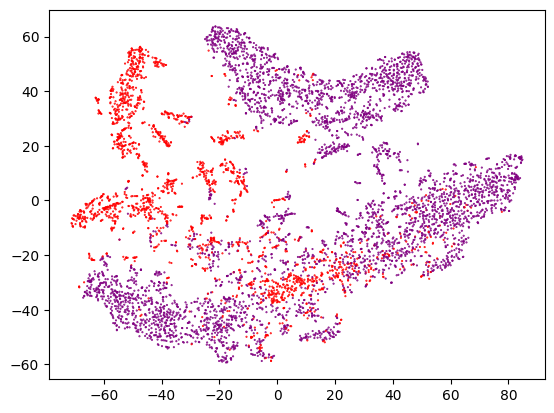

In [19]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

n_components = 2
tsne = TSNE(n_components)
result = tsne.fit_transform(X)

print(result)
plt.scatter( result[:,0], result[:,1], s=.25, label="Data points", c=y, cmap=matplotlib.colors.ListedColormap(colors))

### LOF

n_neighbors =  5
-1.0606476862014877
-1.0883568384309743
-2.335593832040394
n_neighbors =  10
-1.0794434777902873
-1.0960643198040103
-2.6047857212354635
n_neighbors =  50
-1.1195033091330868
-1.1300187121825869
-2.6725328530057793
n_neighbors =  100
-1.12619596854591
-1.1341248779216917
-2.482249380600973


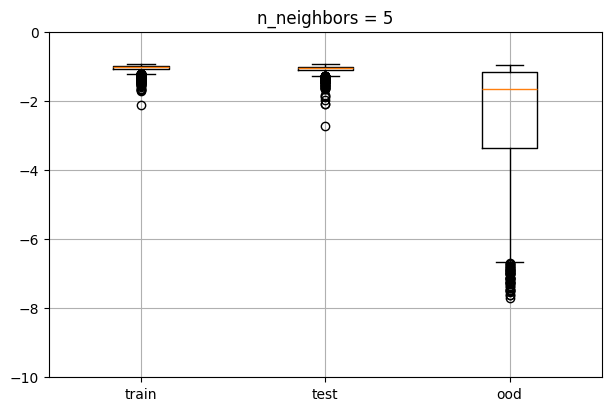

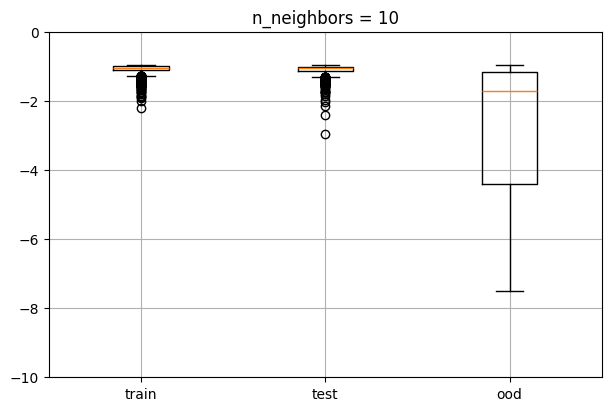

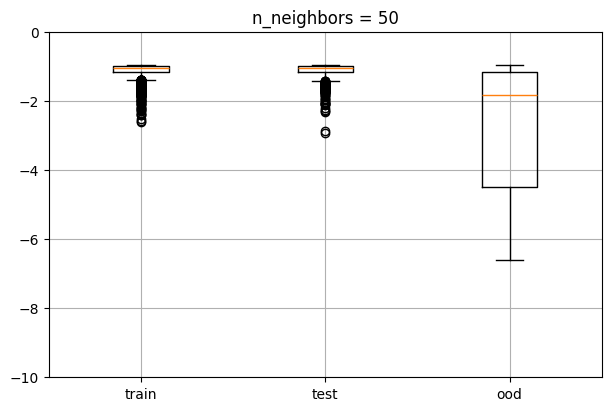

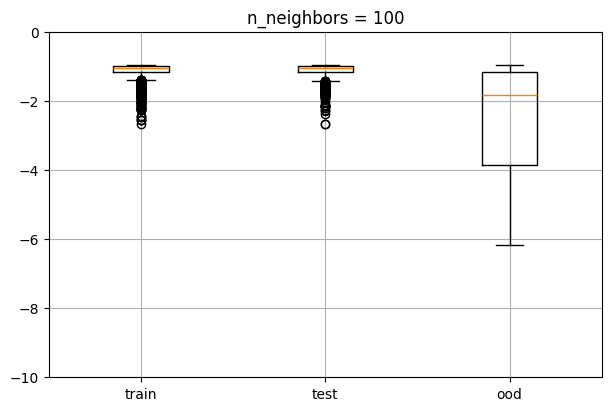

In [64]:
from sklearn.neighbors import LocalOutlierFactor

n_neighbors = [5, 10, 50, 100]
train_scores = []
test_scores = []
ood_scores = []

for i in range(len(n_neighbors)):
    model = LocalOutlierFactor(n_neighbors=n_neighbors[i], novelty=True)
    model.fit(X_train)
    
    train_scores.append(model.score_samples(X_train))
    test_scores.append(model.score_samples(X_test))
    ood_scores.append(model.score_samples(X_ood))

    if 1:
        print('n_neighbors = ', n_neighbors[i])
        print(np.mean(train_scores[i]))
        print(np.mean(test_scores[i]))
        print(np.mean(ood_scores[i]))

    # boxplot
    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
    ax.set_ylim([-10, 0])
    labels = ['train', 'test', 'ood']
    ax.boxplot([train_scores[i], test_scores[i], ood_scores[i]], labels=labels)
    ax.grid()
    string = 'n_neighbors = ' + str(n_neighbors[i])
    plt.title(label = string)

plt.show()

[-0.52797322 -0.14399121 -0.3568254  ... -0.21048041  0.25560412
  0.42218924]


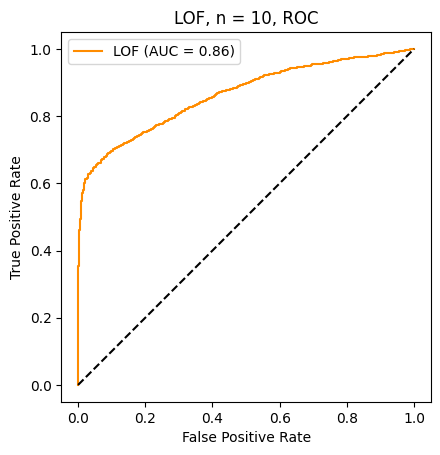

128
-0.1697969180537553
[[1373   79]
 [ 702 1334]]
              precision    recall  f1-score   support

           0       0.66      0.95      0.78      1452
           1       0.94      0.66      0.77      2036

    accuracy                           0.78      3488
   macro avg       0.80      0.80      0.78      3488
weighted avg       0.83      0.78      0.78      3488



In [65]:
# ROC curve
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report

model = LocalOutlierFactor(n_neighbors=10, novelty=True)
model.fit(X_train)

# samples with a negative LOF score (indicating they are less dense than their neighbors) are considered outliers, 
# those with a positive LOF score (indicating they are more dense than their neighbors) are considered inliers
yy_score = -model.decision_function(XX)
print(yy_score)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="LOF",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = "LOF, n = 10, ROC"
plt.title(string)
plt.legend()
plt.show()

# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, yy_score)
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = yy_score.copy()
yy_pred = np.where(yy_score <= 
print(confusion_matrix(yy, y thresholds[np.argmax(tpr - fpr)], 0, 1)
y_pred))
print(classification_report(yy, yy_pred))


[-0.50884281 -0.25287414 -0.4306213  ... -0.36052209 -0.07507856
  0.13357717]


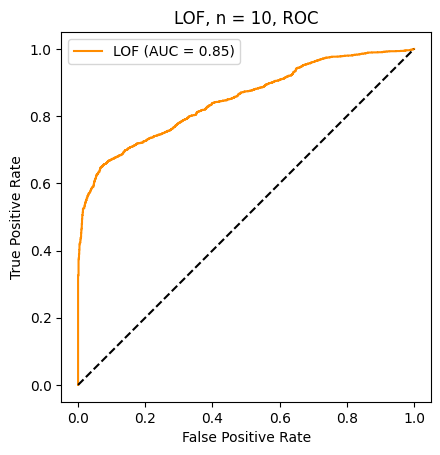

160
-0.060983239312438764
[[1354   98]
 [ 717 1319]]
              precision    recall  f1-score   support

           0       0.65      0.93      0.77      1452
           1       0.93      0.65      0.76      2036

    accuracy                           0.77      3488
   macro avg       0.79      0.79      0.77      3488
weighted avg       0.82      0.77      0.77      3488



In [66]:
# ROC curve
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report

model = LocalOutlierFactor(n_neighbors=50, novelty=True)
model.fit(X_train)

# samples with a negative LOF score (indicating they are less dense than their neighbors) are considered outliers, 
# those with a positive LOF score (indicating they are more dense than their neighbors) are considered inliers
yy_score = -model.decision_function(XX)
print(yy_score)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="LOF",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = "LOF, n = 10, ROC"
plt.title(string)
plt.legend()
plt.show()

# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, yy_score)
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = yy_score.copy()
yy_pred = np.where(yy_score <=  thresholds[np.argmax(tpr - fpr)], 0, 1)

print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))


### kNN

22.247295065030794
25.027812072412242
86.30270299964414


Text(0.5, 1.0, 'n_neighbors = 10')

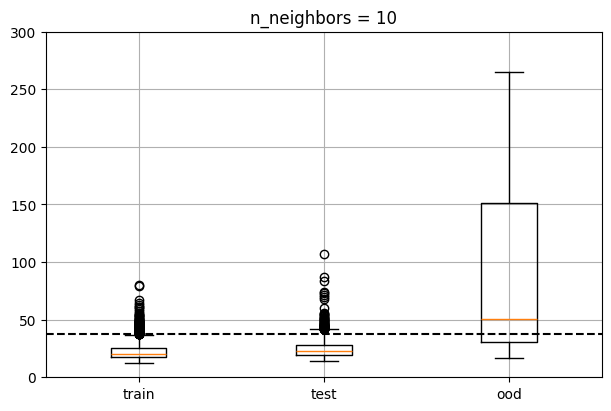

In [67]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = [10, 50, 100]

model = NearestNeighbors(n_neighbors = n_neighbors[0])
model.fit(X_train)

distances, indexes = model.kneighbors(X)
cutoff = [37.13644947795211]
# average distance for each observation over k neighbors
distances_train, indexes_train = model.kneighbors(X_train)
distances_test, indexes_test = model.kneighbors(X_test)
distances_ood, indexes_ood = model.kneighbors(X_ood)

if 1:
    print(np.mean(np.mean(distances_train, axis = 1)))
    print(np.mean(np.mean(distances_test, axis = 1)))
    print(np.mean(np.mean(distances_ood, axis = 1)))
    
# boxplot
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
labels = ['train', 'test', 'ood']
ax.boxplot([np.mean(distances_train, axis = 1), np.mean(distances_test, axis = 1), np.mean(distances_ood, axis = 1)], labels=labels)
ax.grid()
ax.set_ylim([0, 300])
string = 'n_neighbors = ' + str(n_neighbors[0])
plt.axhline(y=cutoff[0], color='k', linestyle='--')
plt.title(label = string)


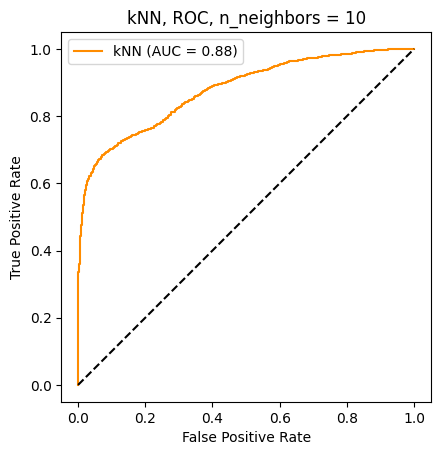

178
37.13644947795211
[0 0 0 ... 0 1 1]
[[1347  105]
 [ 645 1391]]
              precision    recall  f1-score   support

           0       0.68      0.93      0.78      1452
           1       0.93      0.68      0.79      2036

    accuracy                           0.78      3488
   macro avg       0.80      0.81      0.78      3488
weighted avg       0.82      0.78      0.79      3488



In [68]:
ood = []
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report

distances, indexes = model.kneighbors(XX)

RocCurveDisplay.from_predictions(
        yy,
        distances.mean(axis = 1),
        name="kNN",
        color="darkorange",
        pos_label=1
    )
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = 'kNN, ROC, n_neighbors = ' + str(n_neighbors[0])
plt.title(string)
plt.legend()
plt.show()
# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, distances.mean(axis = 1))
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = distances.copy()
yy_pred = np.where(distances.mean(axis=1) <=  thresholds[np.argmax(tpr - fpr)], 0, 1)
print(yy_pred)
print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))



28.85854081769302
29.68587265769208
92.8445850379407


Text(0.5, 1.0, 'n_neighbors = 50')

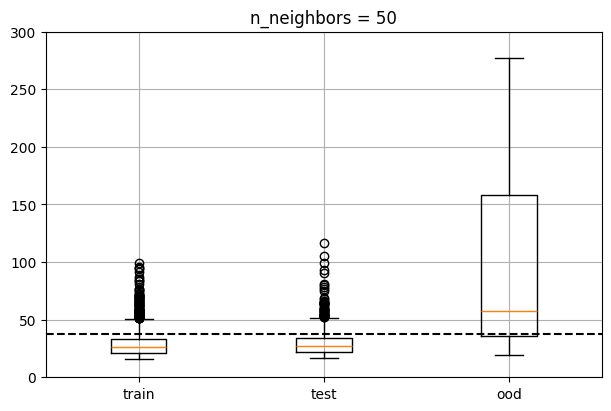

In [69]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = [10, 50, 100]

model = NearestNeighbors(n_neighbors = n_neighbors[1])
model.fit(X_train)

distances, indexes = model.kneighbors(X)
cutoff = [37.13644947795211]
# average distance for each observation over k neighbors
distances_train, indexes_train = model.kneighbors(X_train)
distances_test, indexes_test = model.kneighbors(X_test)
distances_ood, indexes_ood = model.kneighbors(X_ood)

if 1:
    print(np.mean(np.mean(distances_train, axis = 1)))
    print(np.mean(np.mean(distances_test, axis = 1)))
    print(np.mean(np.mean(distances_ood, axis = 1)))
    
# boxplot
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
labels = ['train', 'test', 'ood']
ax.boxplot([np.mean(distances_train, axis = 1), np.mean(distances_test, axis = 1), np.mean(distances_ood, axis = 1)], labels=labels)
ax.grid()
ax.set_ylim([0, 300])
string = 'n_neighbors = ' + str(n_neighbors[1])
plt.axhline(y=cutoff[0], color='k', linestyle='--')
plt.title(label = string)


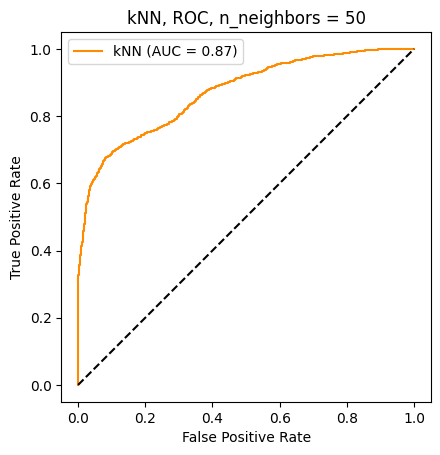

190
44.04221084761636
[0 0 0 ... 0 1 1]
[[1333  119]
 [ 658 1378]]
              precision    recall  f1-score   support

           0       0.67      0.92      0.77      1452
           1       0.92      0.68      0.78      2036

    accuracy                           0.78      3488
   macro avg       0.80      0.80      0.78      3488
weighted avg       0.82      0.78      0.78      3488



In [70]:
ood = []
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report

distances, indexes = model.kneighbors(XX)

RocCurveDisplay.from_predictions(
        yy,
        distances.mean(axis = 1),
        name="kNN",
        color="darkorange",
        pos_label=1
    )
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = 'kNN, ROC, n_neighbors = ' + str(n_neighbors[1])
plt.title(string)
plt.legend()
plt.show()
# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, distances.mean(axis = 1))
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = distances.copy()
yy_pred = np.where(distances.mean(axis=1) <=  thresholds[np.argmax(tpr - fpr)], 0, 1)
print(yy_pred)
print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))



31.88094143635166
32.41514050071469
96.0182703877316


Text(0.5, 1.0, 'n_neighbors = 100')

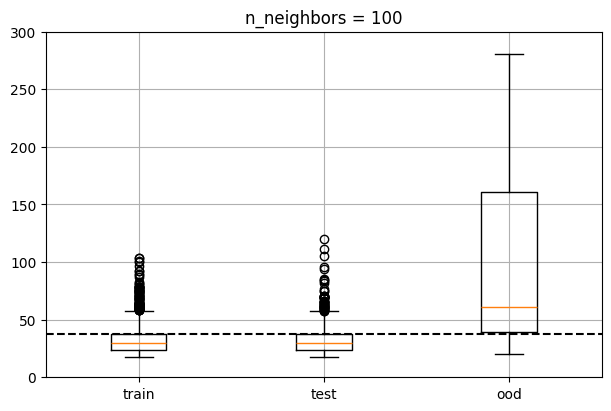

In [71]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = [10, 50, 100]

model = NearestNeighbors(n_neighbors = n_neighbors[2])
model.fit(X_train)

distances, indexes = model.kneighbors(X)
cutoff = [37.13644947795211]
# average distance for each observation over k neighbors
distances_train, indexes_train = model.kneighbors(X_train)
distances_test, indexes_test = model.kneighbors(X_test)
distances_ood, indexes_ood = model.kneighbors(X_ood)

if 1:
    print(np.mean(np.mean(distances_train, axis = 1)))
    print(np.mean(np.mean(distances_test, axis = 1)))
    print(np.mean(np.mean(distances_ood, axis = 1)))
    
# boxplot
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
labels = ['train', 'test', 'ood']
ax.boxplot([np.mean(distances_train, axis = 1), np.mean(distances_test, axis = 1), np.mean(distances_ood, axis = 1)], labels=labels)
ax.grid()
ax.set_ylim([0, 300])
string = 'n_neighbors = ' + str(n_neighbors[2])
plt.axhline(y=cutoff[0], color='k', linestyle='--')
plt.title(label = string)


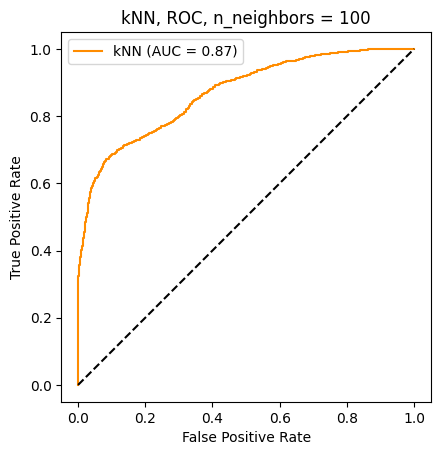

212
47.75114936095317
[0 0 0 ... 0 1 1]
[[1330  122]
 [ 671 1365]]
              precision    recall  f1-score   support

           0       0.66      0.92      0.77      1452
           1       0.92      0.67      0.77      2036

    accuracy                           0.77      3488
   macro avg       0.79      0.79      0.77      3488
weighted avg       0.81      0.77      0.77      3488



In [72]:
ood = []
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report

distances, indexes = model.kneighbors(XX)

RocCurveDisplay.from_predictions(
        yy,
        distances.mean(axis = 1),
        name="kNN",
        color="darkorange",
        pos_label=1
    )
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = 'kNN, ROC, n_neighbors = ' + str(n_neighbors[2])
plt.title(string)
plt.legend()
plt.show()
# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, distances.mean(axis = 1))
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = distances.copy()
yy_pred = np.where(distances.mean(axis=1) <=  thresholds[np.argmax(tpr - fpr)], 0, 1)
print(yy_pred)
print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))



### Elliptical Envelope

contamination =  0.01
-56.09334189917288
-58.971644756771
-554.6300027233037
contamination =  0.05
-56.09334189917288
-58.971644756771
-554.6300027233037
contamination =  0.1
-56.09334189917288
-58.971644756771
-554.6300027233037


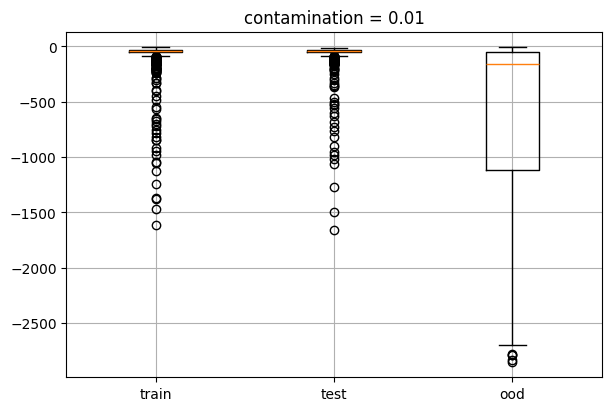

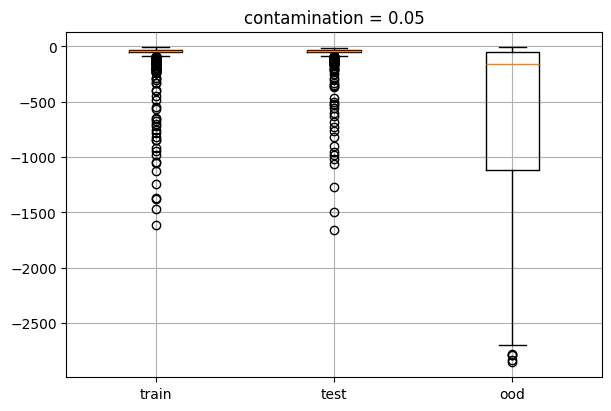

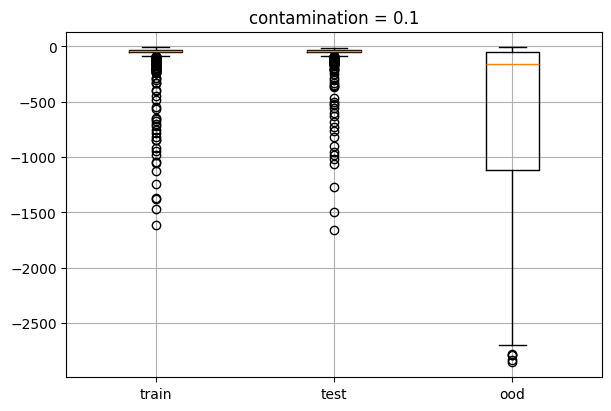

In [73]:
from sklearn.covariance import EllipticEnvelope

cont = [0.01, 0.05, 0.1]
train_scores = []
test_scores = []
ood_scores = []

for i in range(len(cont)):
    model = EllipticEnvelope(contamination=cont[i], random_state=42)

    model.fit(X_train)

    train_scores.append(model.score_samples(X_train))
    test_scores.append(model.score_samples(X_test))
    ood_scores.append(model.score_samples(X_ood))


    if 1:
        print('contamination = ', cont[i])
        print(np.mean(train_scores[i]))
        print(np.mean(test_scores[i]))
        print(np.mean(ood_scores[i]))


    # boxplot
    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

    labels = ['train', 'test', 'ood']
    ax.boxplot([train_scores[i], test_scores[i], ood_scores[i]], labels=labels)
    ax.grid()
    string = 'contamination = ' + str(cont[i])
    plt.title(label = string)

plt.show()

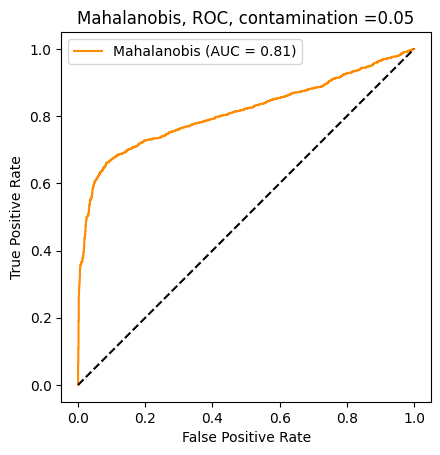

208
-27.042320104545823
[[1329  123]
 [ 691 1345]]
              precision    recall  f1-score   support

           0       0.66      0.92      0.77      1452
           1       0.92      0.66      0.77      2036

    accuracy                           0.77      3488
   macro avg       0.79      0.79      0.77      3488
weighted avg       0.81      0.77      0.77      3488



In [78]:
# ROC curve
from sklearn.metrics import RocCurveDisplay
from sklearn.covariance import EllipticEnvelope

model = EllipticEnvelope(contamination=cont[1], random_state=42)
model.fit(X_train)
yy_score = -model.decision_function(XX)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="Mahalanobis",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = "Mahalanobis, ROC, contamination =" + str(cont[1])
plt.title(string)
plt.legend()
plt.show()

# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, yy_score)
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = yy_score.copy()
yy_pred = np.where(yy_score <=  thresholds[np.argmax(tpr - fpr)], 0, 1)

print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))

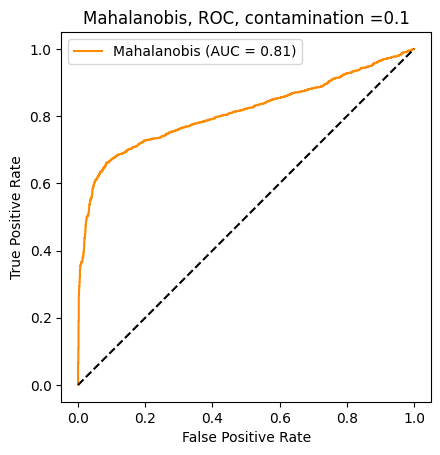

208
3.0125155951256772
[[1329  123]
 [ 691 1345]]
              precision    recall  f1-score   support

           0       0.66      0.92      0.77      1452
           1       0.92      0.66      0.77      2036

    accuracy                           0.77      3488
   macro avg       0.79      0.79      0.77      3488
weighted avg       0.81      0.77      0.77      3488



In [76]:
# ROC curve
from sklearn.metrics import RocCurveDisplay
from sklearn.covariance import EllipticEnvelope

model = EllipticEnvelope(contamination=cont[2], random_state=42)
model.fit(X_train)
yy_score = -model.decision_function(XX)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="Mahalanobis",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
string = "Mahalanobis, ROC, contamination =" + str(cont[2])
plt.title(string)
plt.legend()
plt.show()

# find the best threshold
fpr, tpr, thresholds = sklearn.metrics.roc_curve(yy, yy_score)
print(np.argmax(tpr - fpr))
print(thresholds[np.argmax(tpr - fpr)])

yy_pred = yy_score.copy()
yy_pred = np.where(yy_score <=  thresholds[np.argmax(tpr - fpr)], 0, 1)

print(confusion_matrix(yy, yy_pred))
print(classification_report(yy, yy_pred))